# This notebook shows an example of loading a timeseries at a single point in real time vectors from [HFRnet THREDDS server](http://hfrnet-tds.ucsd.edu/thredds/catalog.html)

Call %matplotlib inline to have plots shown inline in the notebook

%matplotlib inline must be called before any other packages are imported

In [1]:
%matplotlib inline

In [2]:
import netCDF4 as netcdf
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
netcdf.getlibversion()

'4.6.2 of Dec 22 2018 22:51:02 $'

### load 6km USEGC RTV dataset through THREDDS <br>Some other datasets are shown as commented lines below
You must adjust your map parameters if you change regions

In [4]:
#USWC 
#netcdf_data = netcdf.Dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd')

#USEGC region
#netcdf_data = netcdf.Dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')
netcdf_data = netcdf.Dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')
        

### list variables and dimensions

In [6]:
for variable in netcdf_data.variables:
    print(variable,netcdf_data.variables[variable].shape)

lat (460,)
lon (701,)
time (64422,)
time_run (64422,)
site_lat (48,)
site_lon (48,)
site_code (48, 64)
site_netCode (48, 64)
procParams (7,)
time_offset (64422,)
u (64422, 460, 701)
v (64422, 460, 701)
DOPx (64422, 460, 701)
DOPy (64422, 460, 701)


### Show variable information

In [7]:
print(netcdf_data.variables['u'])
print(netcdf_data.variables['v'])

<class 'netCDF4._netCDF4.Variable'>
float32 u(time, lat, lon)
    units: m s-1
    long_name: surface_eastward_sea_water_velocity
    standard_name: surface_eastward_sea_water_velocity
    ancillary_variables: DOPx
    _ChunkSizes: [  1 460 701]
    coordinates: time_run time lat lon 
unlimited dimensions: 
current shape = (64422, 460, 701)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 v(time, lat, lon)
    units: m s-1
    long_name: surface_northward_sea_water_velocity
    standard_name: surface_northward_sea_water_velocity
    ancillary_variables: DOPy
    _ChunkSizes: [  1 460 701]
    coordinates: time_run time lat lon 
unlimited dimensions: 
current shape = (64422, 460, 701)
filling off



### Grab lat, lon and time variables from dataset

In [8]:
lat=netcdf_data.variables['lat'][:]
lon=netcdf_data.variables['lon'][:]
time=netcdf_data.variables['time'][:]

### User input: <br>Location in lat/lon

In [9]:
myLat=25.95
myLon=-79.8
lonIdx=(np.abs(lon-myLon)).argmin()
latIdx=(np.abs(lat-myLat)).argmin()

print("User input:",myLon,myLat)
print("Closest location in grid:", lon[lonIdx],lat[latIdx])

User input: -79.8 25.95
Closest location in grid: -79.822464 25.94328


### User input: <br>start and end times

In [14]:
# Time in UTC
startTime="2018-01-01 00:00 UTC"
endTime="2018-04-21 00:00 UTC"

### Note that Thredds has weird time basis 


In [11]:
print(netcdf_data.variables['time'].units)

hours since 2012-01-01 00:00:00.000 UTC


### Function to turn time index into timestamp

In [12]:
def timeIndexToDatetime(baseTime,times):
    newTimes=[]
    for ts in times:
        newTimes.append(baseTime+datetime.timedelta(hours=ts))

    return newTimes

### turn startTime and endTime into datetime objects

In [15]:
# set the time base
baseTime=datetime.datetime.strptime(netcdf_data.variables['time'].units,"hours since %Y-%m-%d %H:%M:%S.%f %Z")

# Turn time index into timestamps
times=timeIndexToDatetime(baseTime,time)

# find index of start and end time
# This method doesn't handle missing time values
# There needs to be an exact match of time
# needs to be fixed
startTimeDT=datetime.datetime.strptime(startTime, '%Y-%m-%d %H:%M %Z')
startIndex=times.index(startTimeDT)

endTimeDT=datetime.datetime.strptime(endTime, '%Y-%m-%d %H:%M %Z')
endIndex=times.index(endTimeDT)

print("Finding data starting: ",startTime," ending:",endTime)
print("start index: ",startIndex, " end index:", endIndex)

Finding data starting:  2018-01-01 00:00 UTC  ending: 2018-04-21 00:00 UTC
start index:  52551  end index: 55191


### This loads u & v current component data <br> Note the indexing is [time, latitude, longitude]

In [19]:
u=netcdf_data.variables['u'][startIndex:endIndex+1,latIdx,lonIdx];
v=netcdf_data.variables['v'][startIndex:endIndex+1,latIdx,lonIdx];

In [20]:
times=timeIndexToDatetime(baseTime,time[startIndex:endIndex+1])

Text(0.5,0,'Time (UTC)')

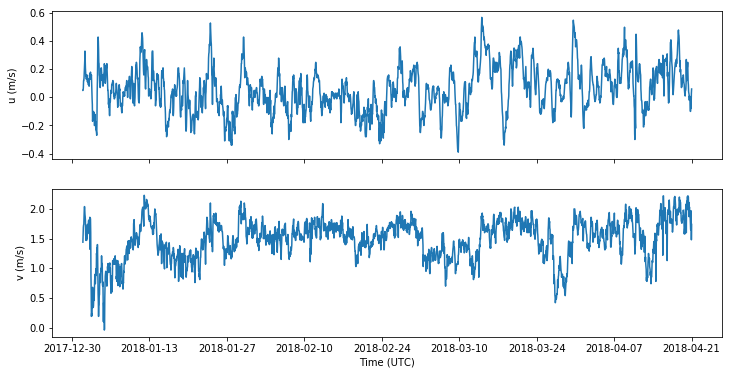

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))
ax1.plot(times,u)
ax1.set_ylabel('u (m/s)')
ax2.plot(times,v)
ax2.set_ylabel('v (m/s)')
ax2.set_xlabel('Time (UTC)')